In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

e_d = pickle.load(open("data/euphoria_posts_drugs.pkl", "rb"))
e_e = pickle.load(open("data/euphoria_posts_non_drug.pkl", "rb"))
e_dp = pickle.load(open("data/euphoria_posts_drugs_labeled.pkl", "rb"))

In [ ]:
print(e_d.shape)
print(e_e.shape)
print(e_dp.shape)

(1746, 8)
(28301, 10)
(106, 11)


In [ ]:
e_d.columns

Index(['author', 'created_utc', 'subreddit', 'title', 'selftext',
       'num_comments', 'score', 'id'],
      dtype='object')

In [ ]:
e_d['all_text'] = e_d['title'] + e_d['selftext']

In [ ]:
e_dp.head()

,author,created_utc,subreddit,title,selftext,num_comments,score,id,all_text,is_personal,is_personal_clean
108,MuffinMuffin_21,2019-06-20 18:16:54,euphoria,I watched the first episode high as fuck.,I think I fell in love with this show when she...,18,72,c2zibg,I watched the first episode high as fuck. I th...,1,1
137,powerfulKRH,2019-06-23 04:32:15,euphoria,Does anyone else think Angus Cloud looks like ...,Just saw episode one. Loved it. Loved the accu...,39,282,c3z6yh,Does anyone else think Angus Cloud looks like ...,1,1
324,BoujeeBoiii,2019-06-28 06:37:55,euphoria,Wow this show really hits...,"I [21M] have really been enjoying this, I was ...",9,107,c6gu71,Wow this show really hits... I [21M] have real...,1,1
473,DRaviolli,2019-07-02 03:38:54,euphoria,this is such a good fucking show,rewatching the show high and silently pointing...,1,7,c84b6p,this is such a good fucking show rewatching th...,1,1
544,southamc,2019-07-03 16:30:42,euphoria,"In episode 1, what does Jules inject herself w...","I’m assuming it’s estrogen, but I’m not sure",1,1,c8q6w7,"In episode 1, what does Jules inject herself w...",1,0


In [ ]:
# subset out edp from ed
e_d_no_p = e_d.drop(e_dp.index)
print(e_d_no_p.shape)

(1640, 9)


In [ ]:
e_d_no_p.head()

In [2]:
# emotion detection
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions", model_max_length=512,
                                          padding = True, truncation = True)
model = AutoModelForSequenceClassification.from_pretrained("SamLowe/roberta-base-go_emotions")

classifier = pipeline(task = "text-classification",
                      model=model,
                      tokenizer = tokenizer,
                      top_k = None)


In [3]:
tokenizer.model_max_length

512

In [ ]:
e_dp_ls = e_dp['all_text'].tolist()
e_d_no_p_ls = e_d_no_p['all_text'].tolist()
e_e_ls = e_e['all_text'].tolist()

In [ ]:
# max_length = 0
# max_index = -1
# for i, string in enumerate(e_dp_ls):
#   if len(string) > max_length:
#     max_length = len(string)
#     max_index = i

# print(f"The position of the longest string in e_dp_ls is: {max_index}")


The position of the longest string in e_dp_ls is: 86


In [ ]:
# blah = e_dp_ls[86]
# len(blah.split())

In [ ]:
# classifier(blah, truncation=True)

In [4]:
def get_top_3_emotions(post):
  # Truncate the post if its length exceeds the maximum length (512 TOKENS)
    # post2 = post.split()
    # if len(post2) > 512:
    #     post3 = post2[:512]
    #     post = ' '.join(post3)

    predictions = classifier(post, truncation = True)

    top_3_emotions = []
    for post_predictions in predictions:
        # Sort predictions based on scores and get the top 3
        top_predictions = sorted(post_predictions, key=lambda x: x['score'], reverse=True)[:3]
        top_3_emotions.append(top_predictions)

    return top_3_emotions

In [ ]:
problem_posts = []
emotion_e_dp = []
for post in e_dp_ls:
  try:
    emotion_e_dp.append(get_top_3_emotions(post))
  except:
    problem_posts.append(post)
    continue

print(len(emotion_e_dp))



106


In [ ]:
e_dp_emo_freqs = {}
for pred in emotion_e_dp:
  for emotion in pred:
    emotion = emotion[0]['label']
    if emotion in e_dp_emo_freqs:
      e_dp_emo_freqs[emotion] += 1
    else:
      e_dp_emo_freqs[emotion] = 1

# sort
e_dp_emo_freqs = {k: v for k, v in sorted(e_dp_emo_freqs.items(), key=lambda item: item[1], reverse=True)}
e_dp_emo_freqs = pd.DataFrame(e_dp_emo_freqs.items(), columns=['Emotion', 'Count'])

In [ ]:
e_dp_emo_freqs

,Emotion,Count
0,curiosity,15
1,love,11
2,sadness,11
3,neutral,10
4,confusion,7
5,amusement,7
6,approval,6
7,admiration,5
8,fear,5
9,annoyance,5


In [ ]:
emotion_e_d_no_p = []
for post in e_d_no_p_ls:
  try:
    emotion_e_d_no_p.append(get_top_3_emotions(post))
  except:
    problem_posts.append(post)
    continue

print(len(emotion_e_d_no_p))

1640


In [ ]:
e_d_no_p_emotion_freq = {}
for pred in emotion_e_d_no_p:
  for emotion in pred:
    emotion = emotion[0]['label']
    if emotion in e_d_no_p_emotion_freq:
      e_d_no_p_emotion_freq[emotion] += 1
    else:
      e_d_no_p_emotion_freq[emotion] = 1

e_d_no_p_emotion_freq = {k: v for k, v in sorted(e_d_no_p_emotion_freq.items(), key=lambda item: item[1], reverse=True)}
e_d_no_p_emotion_freq = pd.DataFrame(e_d_no_p_emotion_freq.items(), columns=['Emotion', 'Count'])

In [ ]:
emotion_e_e = []
for post in e_e_ls:
  try:
    emotion_e_e.append(get_top_3_emotions(post))
  except:
    problem_posts.append(post)
    continue

print(len(emotion_e_e))

28301


In [ ]:
e_e_emotion_freq = {}
for pred in emotion_e_e:
  for emotion in pred:
    emotion = emotion[0]['label']
    if emotion in e_e_emotion_freq:
      e_e_emotion_freq[emotion] += 1
    else:
      e_e_emotion_freq[emotion] = 1

e_e_emotion_freq = {k: v for k, v in sorted(e_e_emotion_freq.items(), key=lambda item: item[1], reverse=True)}
e_e_emotion_freq = pd.DataFrame(e_e_emotion_freq.items(), columns=['Emotion', 'Count'])

In [ ]:
# save
pickle.dump(emotion_e_dp, open("data/emotion_ED_P.pkl", "wb"))
pickle.dump(emotion_e_d_no_p, open("data/emotion_ED_NO_P.pkl", "wb"))
pickle.dump(emotion_e_e, open("data/emotion_E_E.pkl", "wb"))

In [ ]:
# plot freqs
import plotly.express as px
# e_dp_emo_freqs = {k: v for k, v in sorted(e_dp_emo_freqs.items(), key=lambda item: item[1], reverse=True)}
e_dp_emo_freqs = pd.DataFrame(e_dp_emo_freqs.items(), columns=['Emotion', 'Count'])
e_dp_emo_freqs['percent'] = e_dp_emo_freqs['Count'] / e_dp_emo_freqs['Count'].sum() * 100
e_dp_emo_freqs['percent'] = e_dp_emo_freqs['percent'].round(2).astype(str) + '%'

fig = px.bar(e_dp_emo_freqs, x="Emotion", y="Count", text = 'percent')
fig.update_layout(title_text="Emotion Predictions - E_DP")

fig.show()

In [ ]:
fig = px.bar(e_d_no_p_emotion_freq, x="Emotion", y="Count")
fig.update_layout(title_text="Emotion Predictions - E_D No Disclosed Personal Experience")
# show percentage on top of each bar
fig.update_traces(textposition='outside')
fig.show()

In [ ]:
# show just top ten emotions
import plotly.express as px
e_e_emotion_freq2 = e_e_emotion_freq.head(10)
fig = px.bar(e_e_emotion_freq2, x="Emotion", y="Count")
fig.update_layout(title_text="Emotion Predictions - E_E")
fig.show()

In [ ]:
# side by side bar plot of relative proportions
# get proportions
e_dp_emo_freqs['percent'] = e_dp_emo_freqs['Count'] / e_dp_emo_freqs['Count'].sum() * 100
e_dp_emo_freqs['percent'] = e_dp_emo_freqs['percent'].round(2)

e_d_no_p_emotion_freq['percent'] = e_d_no_p_emotion_freq['Count'] / e_d_no_p_emotion_freq['Count'].sum() * 100
e_d_no_p_emotion_freq['percent'] = e_d_no_p_emotion_freq['percent']

e_e_emotion_freq['percent'] = e_e_emotion_freq['Count'] / e_e_emotion_freq['Count'].sum() * 100
e_e_emotion_freq['percent'] = e_e_emotion_freq['percent'].round(2)

In [ ]:
e_dp_emo_freqs.head(10)

,Emotion,Count,percent
0,curiosity,15,14.15
1,love,11,10.38
2,sadness,11,10.38
3,neutral,10,9.43
4,confusion,7,6.60
5,amusement,7,6.60
6,approval,6,5.66
7,admiration,5,4.72
8,fear,5,4.72
9,annoyance,5,4.72


In [ ]:
# one plot with the distributions of each emotion for each group
# put everthing on the same scale
all_emotion_freqs = pd.DataFrame(columns=['Emotion', 'Count', 'Group'])
e_dp_emo_freqs['Group'] = 'E_DP'
e_d_no_p_emotion_freq['Group'] = 'E_D - E_DP'
e_e_emotion_freq['Group'] = 'E_E'
all_emotion_freqs = all_emotion_freqs.append(e_dp_emo_freqs)
all_emotion_freqs = all_emotion_freqs.append(e_d_no_p_emotion_freq)
all_emotion_freqs = all_emotion_freqs.append(e_e_emotion_freq)

<ipython-input-11-d49322a4eebe>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_emotion_freqs = all_emotion_freqs.append(e_dp_emo_freqs)
<ipython-input-11-d49322a4eebe>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_emotion_freqs = all_emotion_freqs.append(e_d_no_p_emotion_freq)
<ipython-input-11-d49322a4eebe>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_emotion_freqs = all_emotion_freqs.append(e_e_emotion_freq)


In [ ]:
# put counts in log scale for each group
# all_emotion_freqs['Count'] = all_emotion_freqs['Count'].astype(float)
# all_emotion_freqs['Log_Count'] = np.log(all_emotion_freqs['Count'])

In [ ]:
all_emotion_freqs.head(10)

,Emotion,Count,Group,percent
0,curiosity,15,E_DP,14.15
1,love,11,E_DP,10.38
2,sadness,11,E_DP,10.38
3,neutral,10,E_DP,9.43
4,confusion,7,E_DP,6.60
5,amusement,7,E_DP,6.60
6,approval,6,E_DP,5.66
7,admiration,5,E_DP,4.72
8,fear,5,E_DP,4.72
9,annoyance,5,E_DP,4.72


In [ ]:
# bar plot of top ten emotions

# all_emotion_freqs = all_emotion_freqs.sort_values(by=['Log_Count'], ascending=False)
# fig = px.bar(all_emotion_freqs, x="Log_Count", y="Emotion", color="Group", orientation='h')
# fig.update_layout(title_text="Emotion Predictions - All Groups",
#                   xaxis_title="Log Count",
#                   yaxis_title="Emotion")
# fig.show()

In [ ]:
all_emotion_freqs.percent.describe()

count    71.000000
mean      4.225352
std       7.409709
min       0.010000
25%       0.876829
50%       1.707317
75%       4.720000
max      42.780000
Name: percent, dtype: float64

In [ ]:
# to cxv
# all_emotion_freqs.to_csv('/content/drive/MyDrive/Colab_Notebooks/euphoria/all_emotion_freqs.csv')

In [ ]:
# exclude gratitude, pride, disgust, embarassment, nervousness, remorse, anger, surprise
# very low freqs
exlude_emotions = ['gratitude', 'pride', 'disgust', 'embarrassment', 'nervousness',
                   'anger', 'surprise', 'remorse', 'joy', 'desire', 'caring']
e_dp_emo_freqs = e_dp_emo_freqs[~e_dp_emo_freqs['Emotion'].isin(exlude_emotions)]
e_d_no_p_emotion_freq = e_d_no_p_emotion_freq[~e_d_no_p_emotion_freq['Emotion'].isin(exlude_emotions)]
e_e_emotion_freq = e_e_emotion_freq[~e_e_emotion_freq['Emotion'].isin(exlude_emotions)]

all_emotion_freqs = all_emotion_freqs[~all_emotion_freqs['Emotion'].isin(exlude_emotions)]

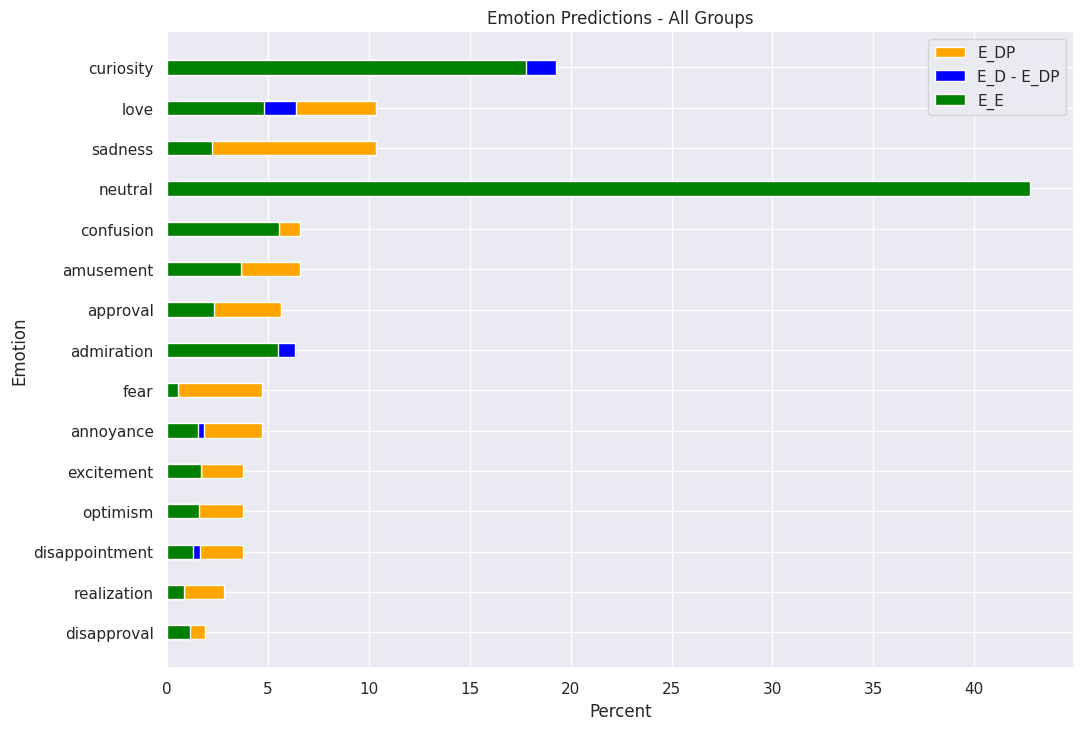

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

width = .35
fig, ax = plt.subplots()
ax.barh(e_dp_emo_freqs['Emotion'], e_dp_emo_freqs['percent'], width, color = 'orange')
ax.barh(e_d_no_p_emotion_freq['Emotion'], e_d_no_p_emotion_freq['percent'], width, color = 'blue')
ax.barh(e_e_emotion_freq['Emotion'], e_e_emotion_freq['percent'], width, color = 'green')

ax.set_xlabel('Percent')
ax.set_ylabel('Emotion')
ax.set_title('Emotion Predictions - All Groups')
ax.invert_yaxis()
ax.legend(['E_DP', 'E_D - E_DP', 'E_E'])
plt.show()

# plt.bar(e_dp_emo_freqs['Emotion'], e_dp_emo_freqs['percent'], color = 'orange')
# plt.bar(e_d_no_p_emotion_freq['Emotion'], e_d_no_p_emotion_freq['percent'], color = 'blue')
# plt.bar(e_e_emotion_freq['Emotion'], e_e_emotion_freq['percent'], color = 'green')
# plt.xlabel('Percent')
# plt.ylabel('Emotion')
# plt.title('Emotion Predictions - All Groups')
# plt.show()


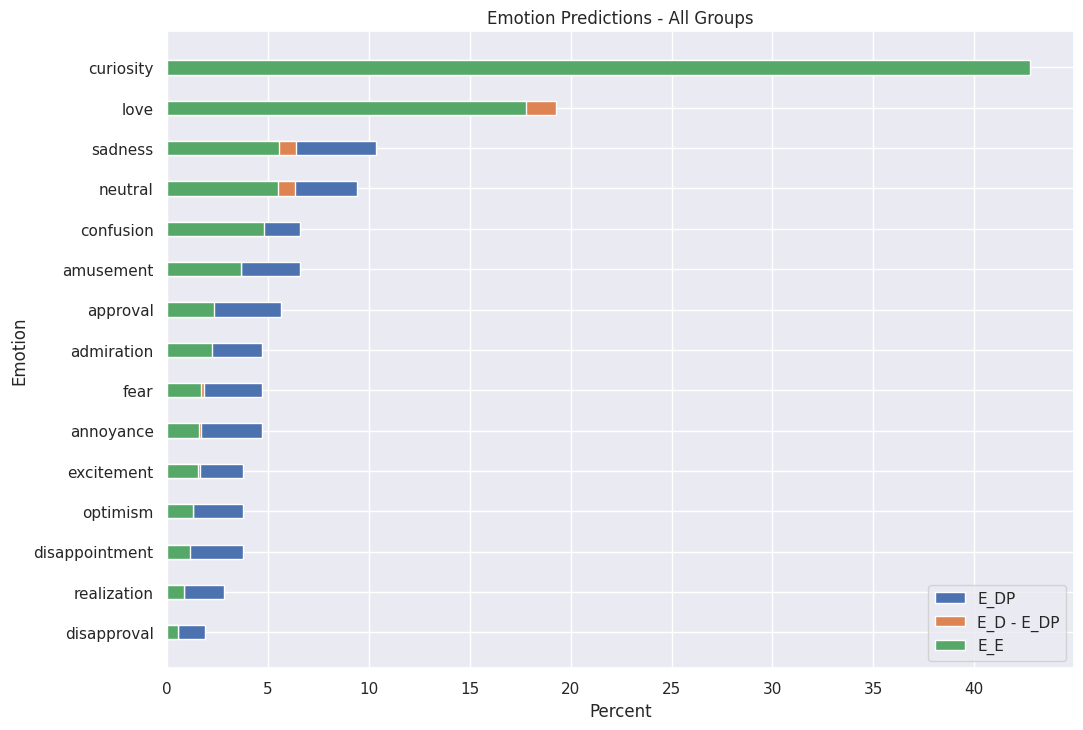

In [ ]:
# all_emotion_freqs = all_emotion_freqs[~all_emotion_freqs['Emotion'].isin(exlude_emotions)]
# emotions = all_emotion_freqs['Emotion'].unique()
# groups = all_emotion_freqs['Group'].unique()

# fig, ax = plt.subplots()
# x_offset = 0
# width = .35


# for group in groups:
#   ax.barh(emotions, all_emotion_freqs[all_emotion_freqs['Group'] == group]['percent'], width, label = group)
#   x_offset += width

# ax.set_xlabel('Percent')
# ax.set_ylabel('Emotion')
# ax.set_title('Emotion Predictions - All Groups')
# ax.invert_yaxis()
# ax.legend(groups)
# plt.show()


<ipython-input-116-50ecf644e459>:10: UserWarning:

The palette list has more values (9) than needed (3), which may not be intended.



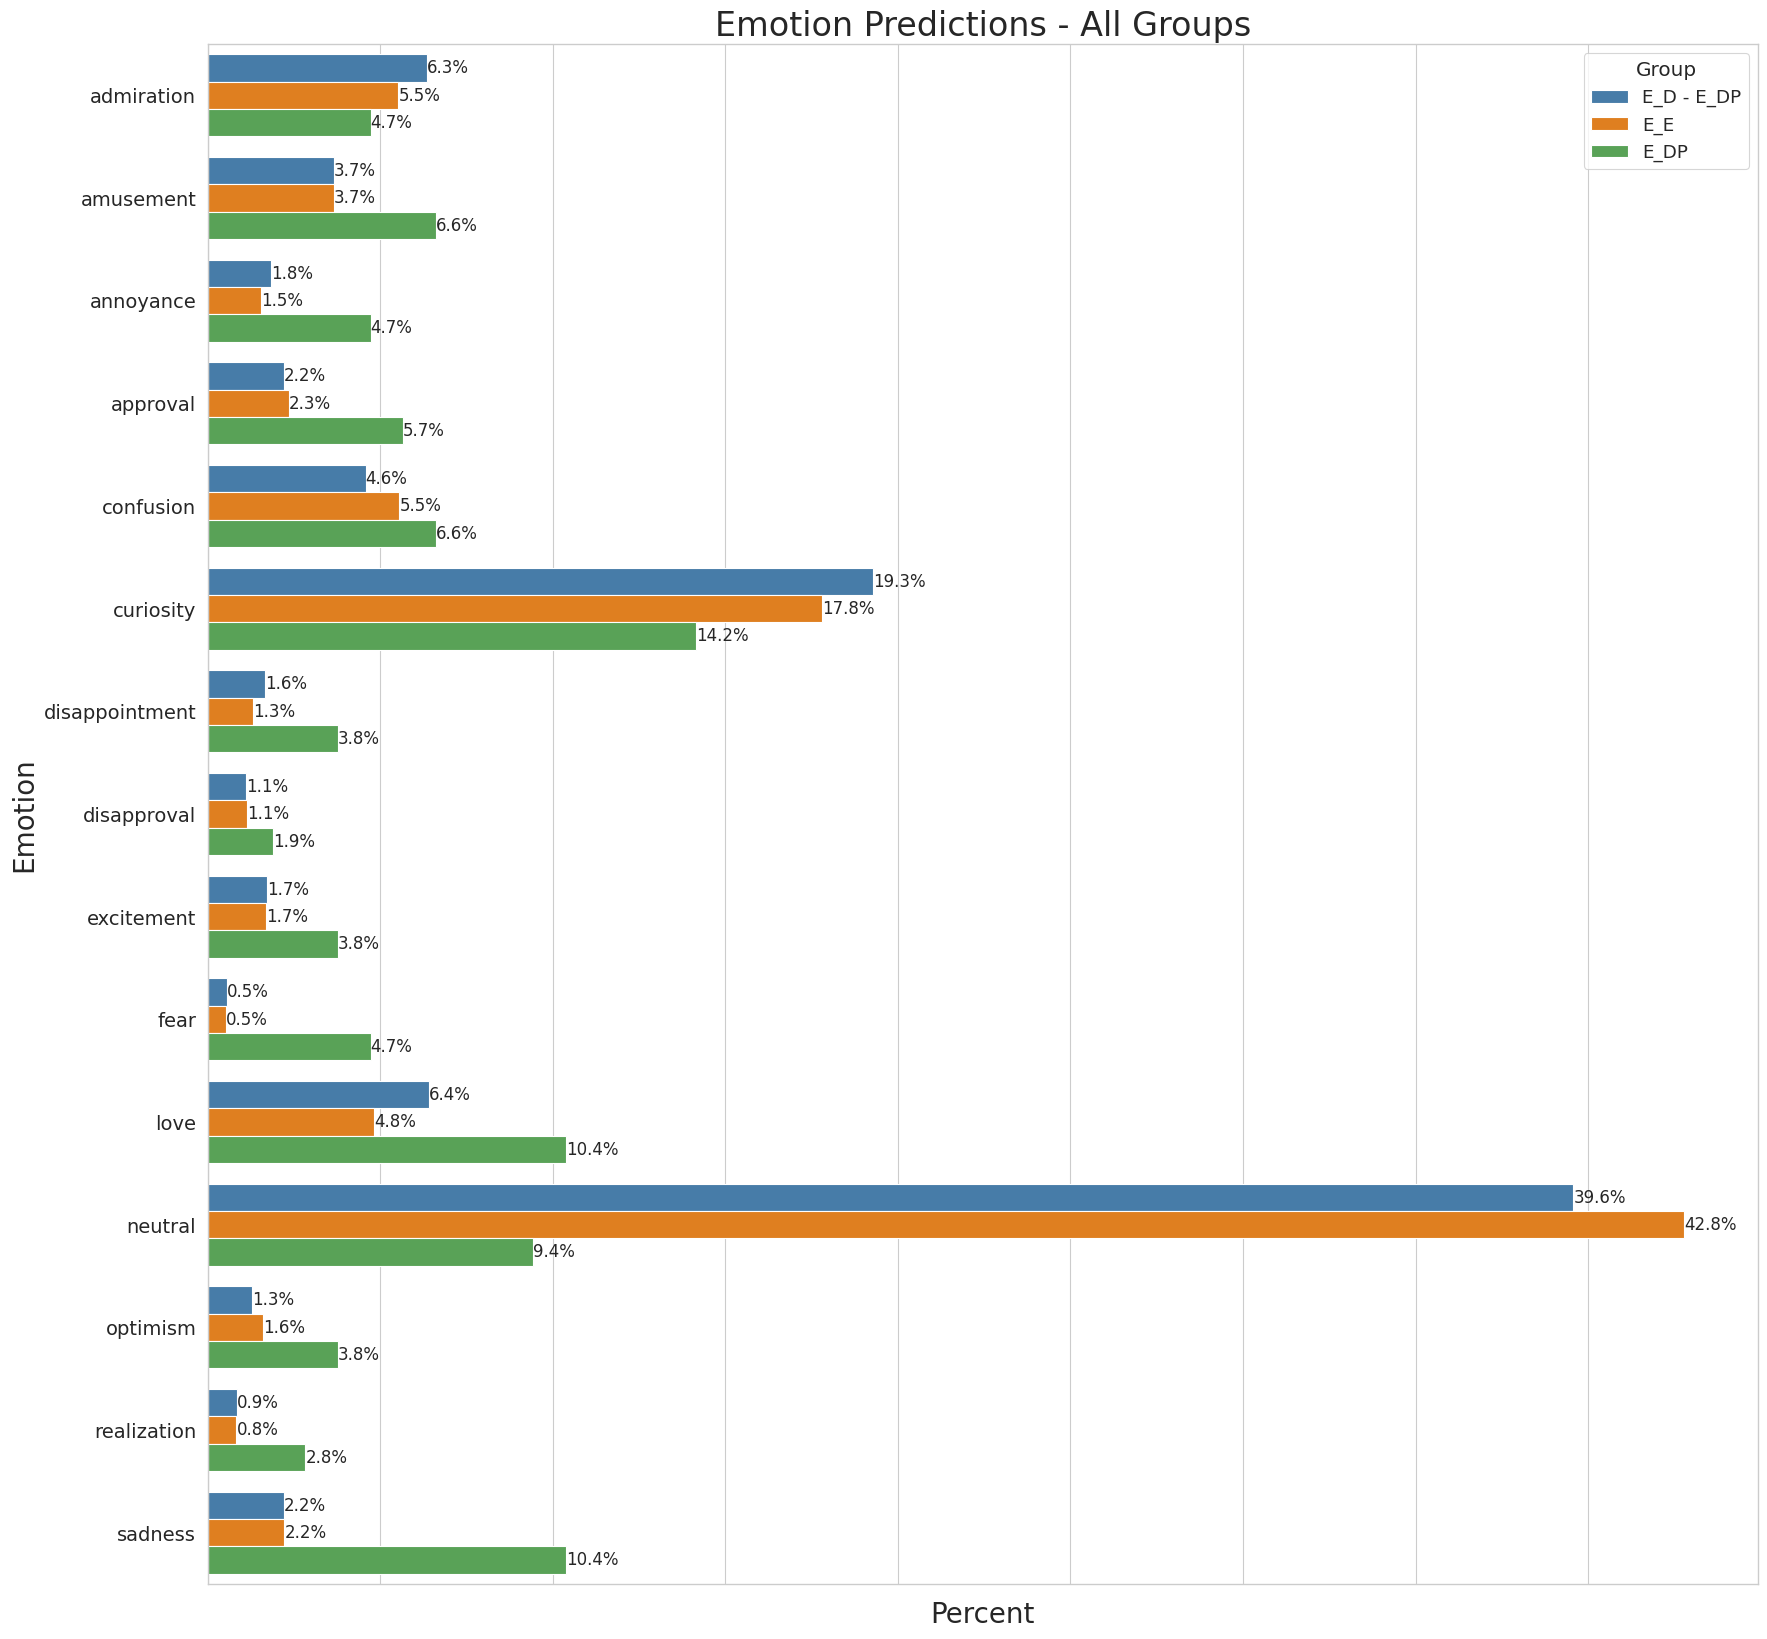

In [ ]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

sns.set(rc={'figure.figsize':(20,20)})
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
# sort data alphabetical and by percent
all_emotion_freqs = all_emotion_freqs.sort_values(by=['Emotion', 'percent'], ascending=[True,False])
p1 = sns.barplot(x="percent", y="Emotion", hue="Group", data=all_emotion_freqs,
                 palette=CB_color_cycle)

# add labels
for p in p1.containers:
    p1.bar_label(p, fmt = '%.1f%%',fontsize=12)

# set labels
p1.set_xlabel("Percent", fontsize = 20)
p1.set_ylabel("Emotion", fontsize = 20)
p1.set_title("Emotion Predictions - All Groups", fontsize=24)
# hide x axis
p1.set_xticklabels([])
p1.tick_params(axis='y', labelsize=14)

# axis labels bolder and bigger
# p1.xaxis.label.set_size(18)
# p1.yaxis.label.set_size(18)
# p1.title.set_size(16)


# plt.savefig('/content/drive/MyDrive/Colab_Notebooks/euphoria/emotion_pred_all.pdf')
plt.show()

<ipython-input-123-0370d0601415>:12: UserWarning:

The palette list has more values (9) than needed (3), which may not be intended.



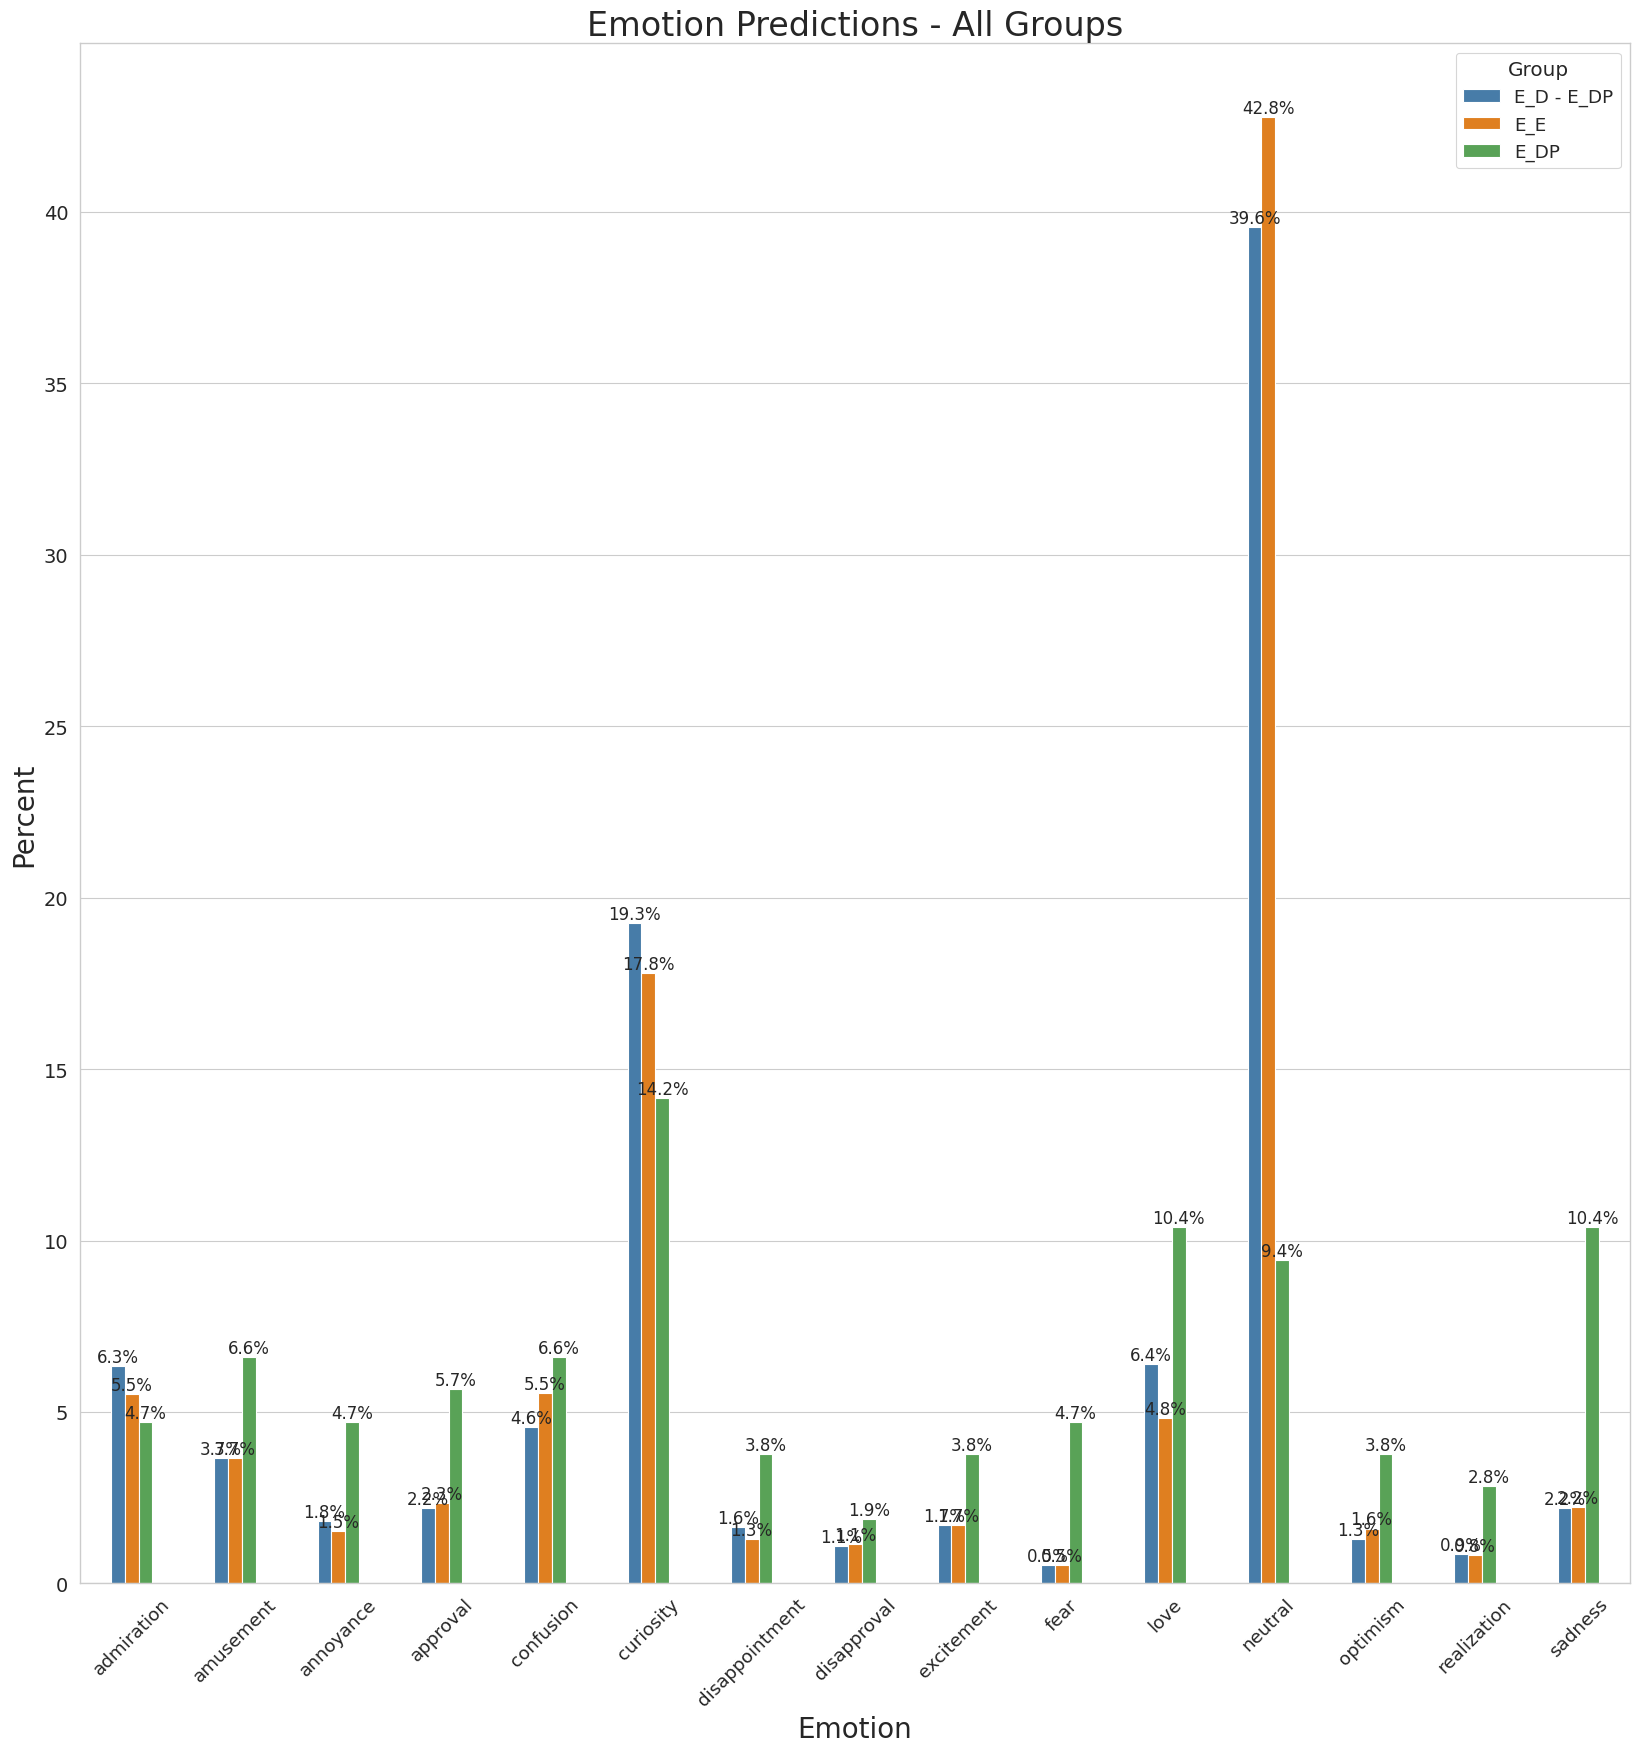

In [ ]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

sns.set(rc={'figure.figsize':(20,20)})
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
# sort data alphabetical and by percent
all_emotion_freqs = all_emotion_freqs.sort_values(by=['Emotion', 'percent'], ascending=[True,False])
# add space between bars

p1 = sns.barplot(x="Emotion", y="percent", hue="Group", data=all_emotion_freqs,
                 palette=CB_color_cycle, width=0.4)

# add labels
for p in p1.containers:
    p1.bar_label(p, fmt = '%.1f%%',fontsize=12)

# set labels
p1.set_xlabel("Emotion", fontsize = 20)
p1.set_ylabel("Percent", fontsize = 20)
p1.set_title("Emotion Predictions - All Groups", fontsize=24)
# hide x axis
plt.xticks(rotation = 45)
p1.tick_params(axis='y', labelsize=14)

# axis labels bolder and bigger
# p1.xaxis.label.set_size(18)
# p1.yaxis.label.set_size(18)
# p1.title.set_size(16)


# plt.savefig('/content/drive/MyDrive/Colab_Notebooks/euphoria/emotion_pred_all.pdf')
plt.show()

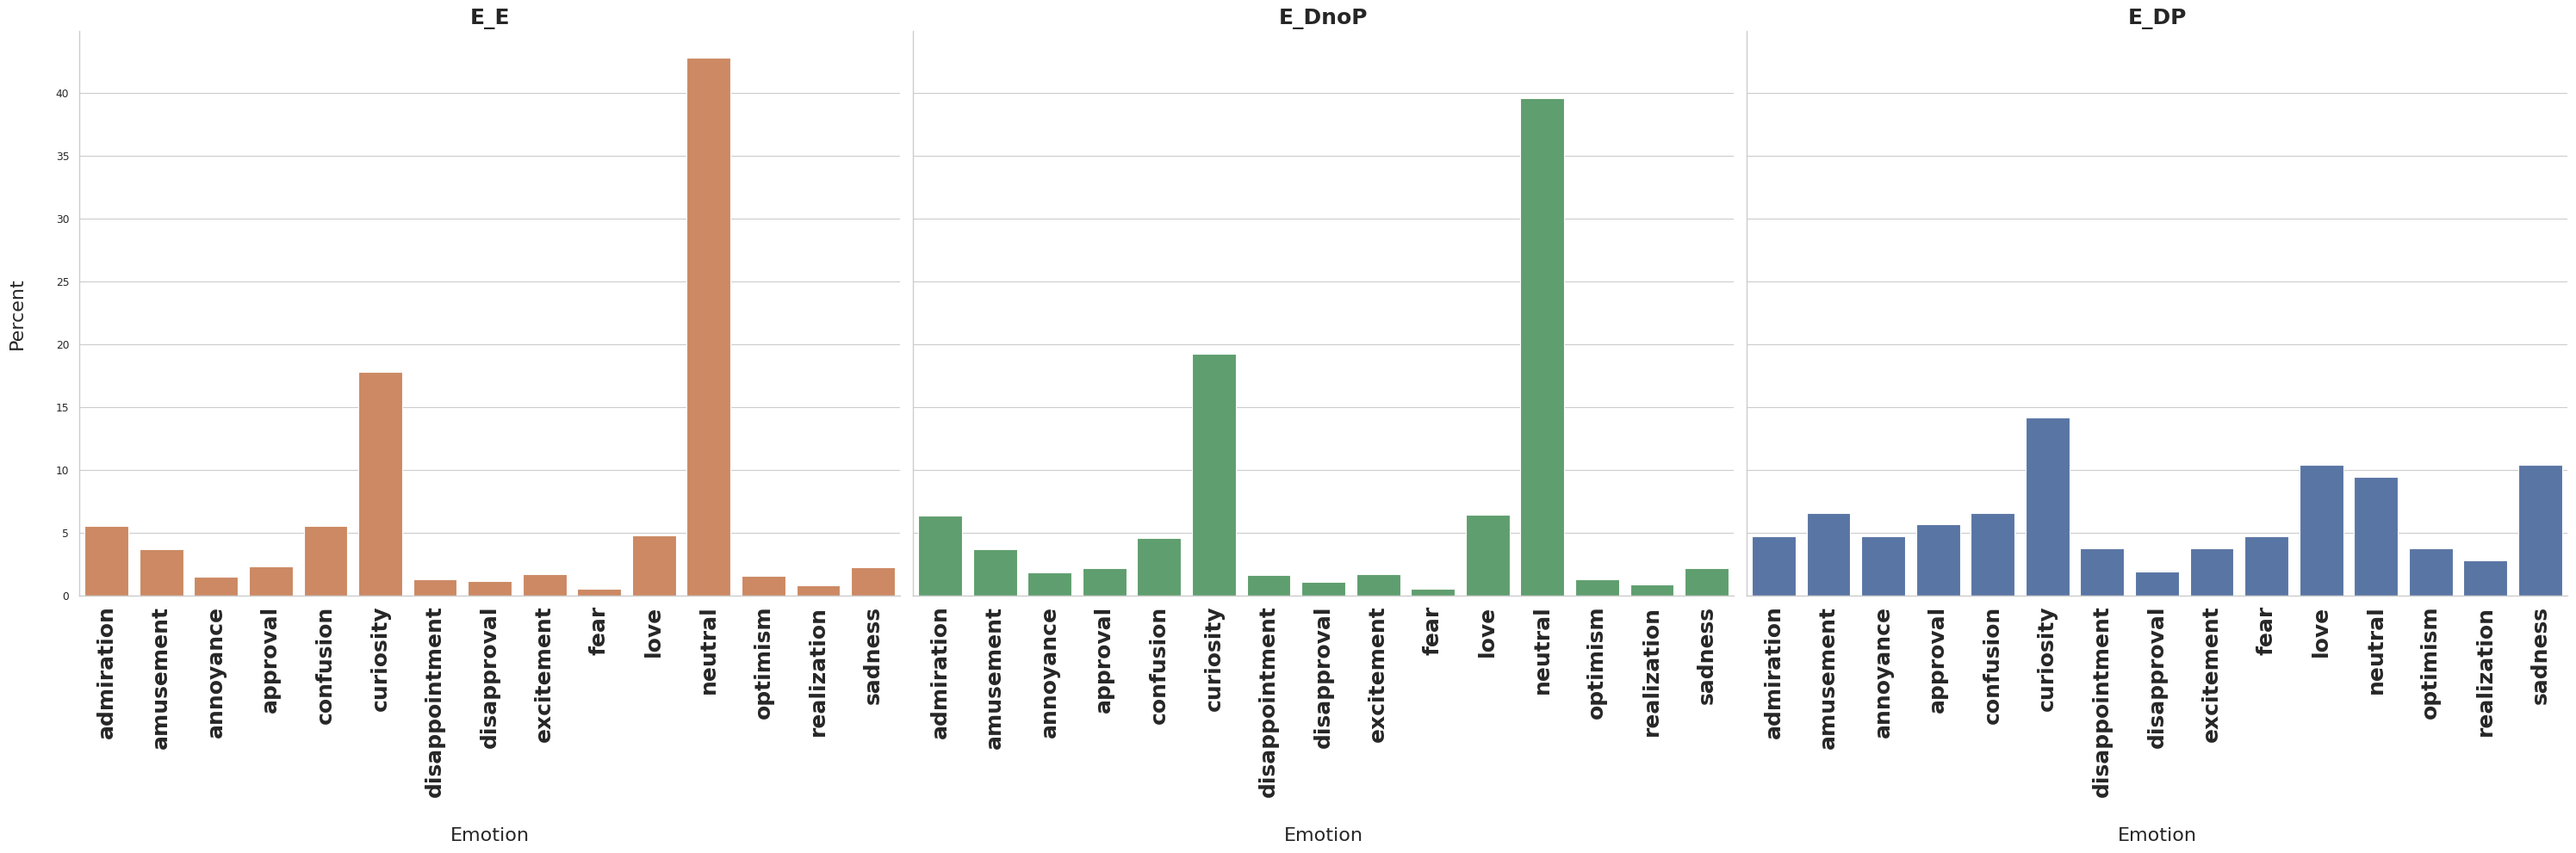

In [ ]:
# facet wrap bar plots
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator


all_emotion_freqs = all_emotion_freqs.sort_values(by=['Emotion', 'percent'])
# data_x = list(all_emotion_freqs['Group'])

sns.set_style("whitegrid", {"font.color": "black"})
# sns.set_context("paper")

# all_emotion_freqs['Color'] = pd.Series(list(pd.factorize(all_emotion_freqs['Group']))[0]).map(lambda x: sns.color_palette()[x])

g = sns.FacetGrid(all_emotion_freqs, col="Group", col_order = ["E_E", "E_D - E_DP", "E_DP"], height=10, hue = "Group") \
   .map(sns.barplot, "Emotion", "percent", dodge=False) \
   .set_titles("{col_name}", weight="bold") \
   .set_axis_labels("Emotion", "Percent", fontsize=16, labelpad=25)\
   .set_xticklabels(rotation = 90, fontsize=18, weight='bold', ha = 'center') \

# g.set_xticklabels(rotation = 60, fontsize=18, weight='bold')
# g.set_titles("{col_name}", weight='bold')
# g.set_axis_labels("Emotion", "Percent", fontsize=16, labelpad=25)

# plt.subplots_adjust(wspace=1.1)
for ax in g.axes.flat:
  ax.set_title(ax.get_title().replace("E_D - E_DP", "E_DnoP"), fontsize=18, weight='bold')
  # ax.set_xticklabels(ax.get_xticklabels(), rotation=70)

g.tight_layout()
# g.legend.remove()
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/euphoria/emotion_pred_all2.pdf')
plt.show()

In [ ]:
# save
pickle.dump(emotion_e_dp, open("/content/drive/MyDrive/Colab_Notebooks/euphoria/emotion_ED_P.pkl", "wb"))
pickle.dump(emotion_e_d_no_p, open("/content/drive/MyDrive/Colab_Notebooks/euphoria/emotion_ED_NO_P.pkl", "wb"))
pickle.dump(emotion_e_e, open("/content/drive/MyDrive/Colab_Notebooks/euphoria/emotion_E_E.pkl", "wb"))